# DS-GA1001: Churn Prediction 

Mingzhen Li (ml5831)<br />
Tingjun Man (tm2838)<br />

In this task, we are going to predict the probability of whether a person would leave the network. 

In [33]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from scipy import sparse, stats

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
y_train_o = train.LEAVE.values
target = train.LEAVE
print(train.shape, test.shape)

(18000, 12) (2000, 11)


# Part One: Exploratory Data Analysis

### Check Missing Data

In [35]:
# Check whether there is any missing data
train.isnull().any()


COLLEGE                        False
INCOME                         False
OVERAGE                        False
LEFTOVER                       False
HOUSE                          False
HANDSET_PRICE                  False
OVER_15MINS_CALLS_PER_MONTH    False
AVERAGE_CALL_DURATION          False
REPORTED_SATISFACTION          False
REPORTED_USAGE_LEVEL           False
CONSIDERING_CHANGE_OF_PLAN     False
LEAVE                          False
dtype: bool

No missing data observed.

### Recode Categorical Variables

In [36]:
dict_col = {'zero': 0,
            'one': 1,
           }
dict_sat = {'very_unsat': 0,
            'unsat': 1,
            'avg': 2,
            'sat': 3,
            'very_sat': 4,
           }
dict_usage = {'very_little': 0,
              'little': 1,
              'avg': 2,
              'high': 3,
              'very_high': 4, 
             }

dict_plan = {'never_thought': 4,
             'no': 3, 
             'perhaps': 2,
             'considering': 1,
             'actively_looking_into_it': 0,
            }

train['COLLEGE'] = train['COLLEGE'].map(dict_col)
train['REPORTED_SATISFACTION'] = train['REPORTED_SATISFACTION'].map(dict_sat)
train['REPORTED_USAGE_LEVEL'] = train['REPORTED_USAGE_LEVEL'].map(dict_usage)
train['CONSIDERING_CHANGE_OF_PLAN'] = train['CONSIDERING_CHANGE_OF_PLAN'].map(dict_plan)

test['COLLEGE'] = test['COLLEGE'].map(dict_col)
test['REPORTED_SATISFACTION'] = test['REPORTED_SATISFACTION'].map(dict_sat)
test['REPORTED_USAGE_LEVEL'] = test['REPORTED_USAGE_LEVEL'].map(dict_usage)
test['CONSIDERING_CHANGE_OF_PLAN'] = test['CONSIDERING_CHANGE_OF_PLAN'].map(dict_plan)


### Correlation Matrix

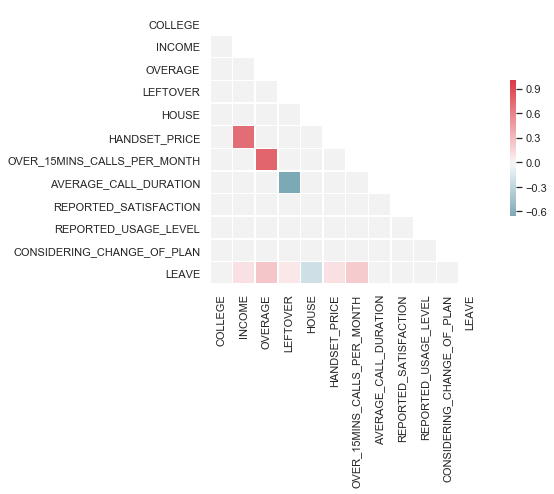

In [37]:
sns.set(style="white")

corr = train.iloc[:,:].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

According to this correlation matrix, only __INCOME, OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE and OVER_15MINS_CALLS_PER_MONTH__ show a correlation with the decision to leave the network.

### Visualizations

In [38]:
# train['AVERAGE_CALL_DURATION_Cat'] = train['AVERAGE_CALL_DURATION']
# for i in range(train.shape[0]):
#     if train['AVERAGE_CALL_DURATION'][i] >= 0 and train['AVERAGE_CALL_DURATION'][i] <= 10:
#         train['AVERAGE_CALL_DURATION_Cat'][i,13] = 0
#     else: 
#         train['AVERAGE_CALL_DURATION_Cat'][i,13] = 1
train['AVERAGE_CALL_DURATION_Cat'] = train['AVERAGE_CALL_DURATION'].apply(lambda x: 0 if x>=0 or x <=10 else 1)

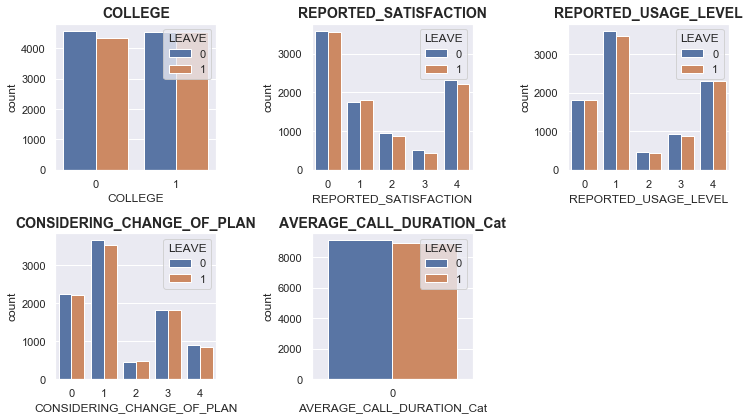

In [39]:
sns.set(rc={'figure.figsize':(10,5)})

cols = ['COLLEGE', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN',
        'AVERAGE_CALL_DURATION_Cat']

nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):          
        i = r*nr_cols+c 
        if i <= len(cols)-1:
            ax = axs[r][c]
            sns.countplot(train[cols[i]], hue=train["LEAVE"], ax=ax)
            ax.set_title(cols[i], fontsize=14, fontweight='bold')
            ax.legend(title="LEAVE", loc='best') 
        else: break

axs.ravel()[-1].set_visible(False)          
plt.tight_layout()   


Consistent with the correlation matrix, there is no significant difference between the number of people who leave and who stay at the network across different subclasses of these variables. <br/>
However, to capture all the variabilities, we still include them in the modeling.


# Part Two: Modeling & Training

### New Feature Generation
Generate new features based on the original set of features to obtain new information.

In [40]:
train['multi'] = train.OVER_15MINS_CALLS_PER_MONTH / train.AVERAGE_CALL_DURATION
test['multi'] = test.OVER_15MINS_CALLS_PER_MONTH / test.AVERAGE_CALL_DURATION


In [41]:
del train['LEAVE'] 
del train['AVERAGE_CALL_DURATION_Cat']

X_train = train.values
X_test = test.values
y_train = y_train_o
print(X_train.shape, X_test.shape)


(18000, 12) (2000, 12)


### LightGBM

fold n°1
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.840456	valid_1's auc: 0.77576
[100]	training's auc: 0.874788	valid_1's auc: 0.773495
Early stopping, best iteration is:
[60]	training's auc: 0.848544	valid_1's auc: 0.776271
fold n°2
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.840397	valid_1's auc: 0.778746
Early stopping, best iteration is:
[7]	training's auc: 0.794922	valid_1's auc: 0.780732
fold n°3
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.842207	valid_1's auc: 0.780484
Early stopping, best iteration is:
[24]	training's auc: 0.814723	valid_1's auc: 0.784327
fold n°4
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.843143	valid_1's auc: 0.770877
Early stopping, best iteration is:
[12]	training's auc: 0.804238	valid_1's auc: 0.777347
fold n°5
Training until validation scores don't improve for 50 rounds.
[50]	training's auc:

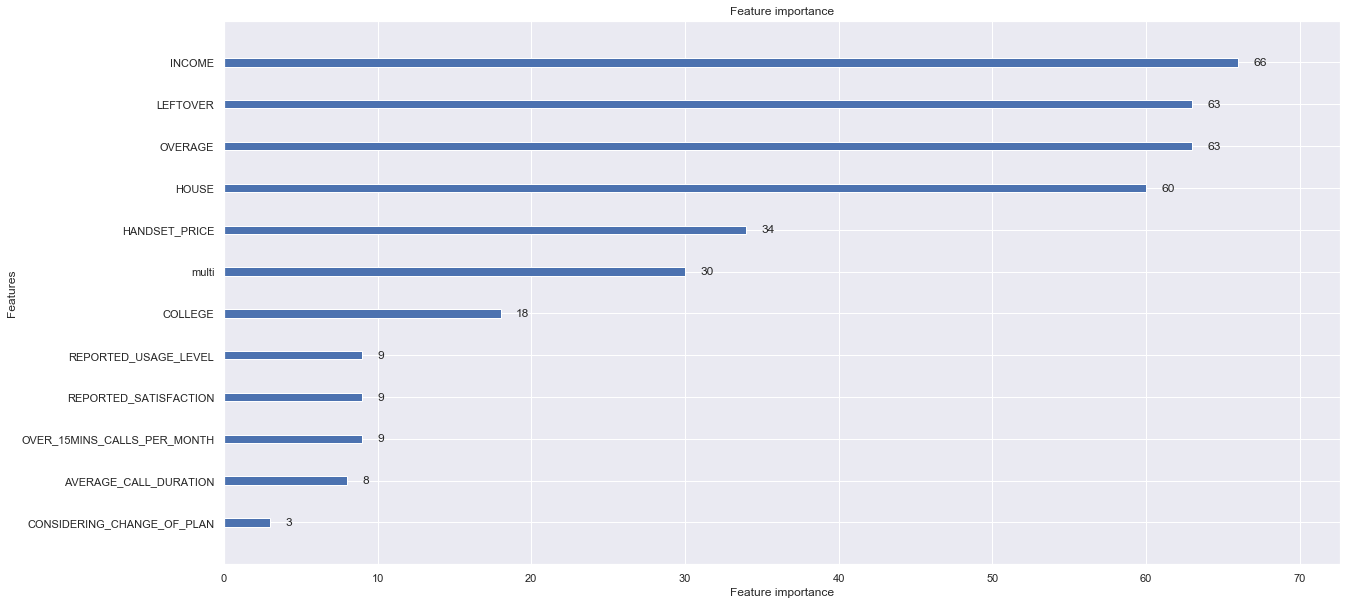

In [42]:
param = {'num_leaves': 32,
         'min_data_in_leaf': 10, 
#              'min_child_sample':20,
         'objective':'binary',
#              'max_depth': 7,
         'learning_rate': 0.1,
         "boosting": "gbdt",
#              "feature_fraction": 0.9,
         'metrics': 'auc',
#              "bagging_freq": 1,
#              "bagging_fraction": 0.9,
#              "bagging_seed": 2019,
#              "lambda_l1": 0.03,
#              'lambda_l2': 0.01,
         "verbosity": -1
        }
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_lgb = np.zeros(X_train.shape[0])
predictions_lgb = np.zeros(X_test.shape[0])

val_idx_list = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx], 
                           feature_name=list(train.columns)
                          )
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])
    val_idx_list.append(val_idx)
    num_round = 10000
    clf = lgb.train(param, 
                    trn_data, 
                    num_round, 
                    valid_sets = [trn_data, val_data], 
#                         feval = accuracy,
                    verbose_eval=50,
                    early_stopping_rounds = 50)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
#         print( "auc = ", roc_auc_score(y_train[val_idx],oof_lgb[val_idx]))
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
lgb.plot_importance(clf, figsize=(20,10), max_num_features=30)
print( "auc = ", roc_auc_score(y_train, oof_lgb))
# print( "test auc = ", roc_auc_score(y_test, predictions_lgb))

### XGBoost

In [43]:
xgb_params = {'eta': 0.02, 
              'max_depth': 7, 
#               'subsample': 0.8, 
#               'colsample_bytree': 0.6, 
#               'lambda': 10, 
#               'alpha': 0.1,
#               'gamma': 10,
              'objective': 'reg:linear', 
#               'min_samples_leaf':50,
              'eval_metric': 'auc', 
#               'min_child_weight': 3,
              'silent': True, 
              'nthread': 4
             }

folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb = np.zeros(X_train.shape[0])
predictions_xgb = np.zeros(X_test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, 
                    num_boost_round=20000, 
                    evals=watchlist, 
                    early_stopping_rounds=100,
                    verbose_eval=50, 
                    maximize=True,
                    params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print( "auc = ", roc_auc_score(y_train, oof_xgb))
# print( "auc = ", roc_auc_score(y_test, predictions_xgb))

fold n°1
[0]	train-auc:0.803492	valid_data-auc:0.760687
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 100 rounds.
[50]	train-auc:0.832118	valid_data-auc:0.771513
[100]	train-auc:0.847227	valid_data-auc:0.770969
[150]	train-auc:0.85835	valid_data-auc:0.773295
[200]	train-auc:0.866433	valid_data-auc:0.773254
[250]	train-auc:0.873532	valid_data-auc:0.773531
[300]	train-auc:0.880088	valid_data-auc:0.773225
[350]	train-auc:0.886819	valid_data-auc:0.773088
Stopping. Best iteration:
[268]	train-auc:0.876013	valid_data-auc:0.773639

fold n°2
[0]	train-auc:0.799115	valid_data-auc:0.774361
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 100 rounds.
[50]	train-auc:0.827656	valid_data-auc:0.777838
[100]	train-auc:0.842696	valid_data-auc:0.777987
Stopping. Best iteration:
[30]	train-auc:0.819875	valid_data-auc:0

### Decision Tree

In [44]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

folds = KFold(n_splits=5, shuffle=True, random_state= 2017)
oof_dt = np.zeros(X_train.shape[0])
predictions_dt = np.zeros(X_test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    dt = DecisionTreeClassifier(max_depth = 5, 
#                                 min_samples_leaf=10,
#                                 max_features=0.9,
                                random_state=2017)
    dt.fit(X_train[trn_idx], y_train[trn_idx])
    oof_dt[val_idx] = dt.predict_proba(X_train[val_idx])[:,1]
    predictions_dt += dt.predict_proba(X_test)[:,1]/folds.n_splits

print( "auc = ", roc_auc_score(y_train, oof_dt))
# print( "auc = ", roc_auc_score(y_test, predictions_dt))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
auc =  0.767097989049444


### CatBoost

In [45]:
from catboost import Pool, CatBoostRegressor

folds = KFold(n_splits=5, shuffle=True, random_state= 2016)
oof_cat = np.zeros(len(X_train))
predictions_cat = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    cat = CatBoostRegressor(n_estimators=20000,
                            use_best_model=True,
                            learning_rate=0.05, 
                            depth=7, 
#                             bootstrap_type = 'Bernoulli',
                            l2_leaf_reg=10,
#                             subsample=0.6,
                            loss_function='RMSE',
                            eval_metric= 'AUC',
                            verbose=50,
                            early_stopping_rounds=50,
                            random_seed=2019,
                            thread_count=4,
                           )
    trn_data = Pool(X_train[trn_idx], label=y_train[trn_idx])
    val_data = Pool(X_train[val_idx], label=y_train[val_idx])
    cat.fit(trn_data, eval_set = val_data)
    oof_cat[val_idx] = cat.predict(X_train[val_idx])
    predictions_cat += cat.predict(X_test)/folds.n_splits
print( "auc = ", roc_auc_score(y_train, oof_cat))
# print( "auc = ", roc_auc_score(y_test, predictions_cat))


fold n°1
0:	test: 0.7560985	best: 0.7560985 (0)	total: 46.3ms	remaining: 15m 25s
50:	test: 0.7643971	best: 0.7644762 (46)	total: 2.36s	remaining: 15m 23s
100:	test: 0.7684140	best: 0.7684140 (100)	total: 4.45s	remaining: 14m 35s
150:	test: 0.7696948	best: 0.7697189 (148)	total: 6.47s	remaining: 14m 11s
200:	test: 0.7700976	best: 0.7701183 (199)	total: 8.58s	remaining: 14m 5s
250:	test: 0.7696602	best: 0.7701952 (202)	total: 10.5s	remaining: 13m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7701951732
bestIteration = 202

Shrink model to first 203 iterations.
fold n°2
0:	test: 0.7704056	best: 0.7704056 (0)	total: 50.6ms	remaining: 16m 52s
50:	test: 0.7761067	best: 0.7761067 (50)	total: 2.46s	remaining: 16m 1s
100:	test: 0.7806228	best: 0.7806228 (100)	total: 4.53s	remaining: 14m 52s
150:	test: 0.7811404	best: 0.7813457 (107)	total: 6.53s	remaining: 14m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7813456809
bestIteration = 107

Shrink

### Stacking of four models

In [46]:
# stacking
train_stack = np.vstack([oof_lgb, oof_xgb, oof_dt, oof_cat]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb, predictions_dt, predictions_cat]).transpose()

folds_stack = KFold(n_splits=5, random_state=2015)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    stacking = BayesianRidge(
        fit_intercept=False, 
    )
    stacking.fit(trn_data, trn_y)
    oof_stack[val_idx] = stacking.predict(val_data)
    predictions += stacking.predict(test_stack) / folds_stack.n_splits

print( "auc = ", roc_auc_score(y_train, oof_stack))
# print( "auc = ", roc_auc_score(y_test, predictions))


fold 0
fold 1
fold 2
fold 3
fold 4
auc =  0.7747197129715425


# Part Three: Output

In [16]:
sub.LEAVE = predictions
sub.to_csv('sub030801.csv', index=False)